In [77]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pytorch_lightning as pl
import torch
from torch import nn
import torch.nn.functional as F

In [78]:
u1_images=[]
u1_masks=[]
for f in os.listdir("train_u1/"):
    if f.startswith("im_"):
        u1_images.append(np.asarray(Image.open("train_u1/"+f)))
        u1_masks.append(np.asarray(Image.open("train_u1/"+f.replace("im_","mask_"))))

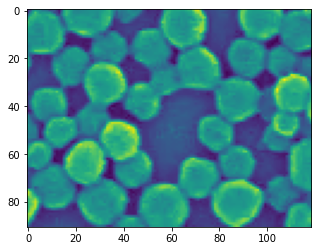

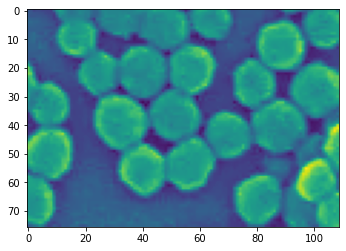

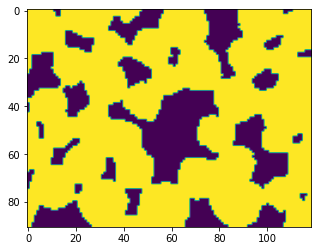

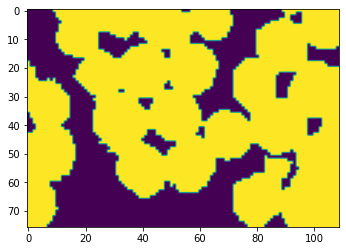

In [79]:
u1_images=[i.mean(axis=2) if len(i.shape)>2 else i for i in u1_images]
for i in u1_images:
    plt.imshow(i)
    plt.show()
    plt.close()

u1_masks=[(i[:,:,0]<100).astype(int) if len(i.shape)>2 else i for i in u1_masks]
for i in u1_masks:
    plt.imshow(i)
    plt.show()
    plt.close()

In [39]:
class Unet(pl.LightningModule):
    def __init__(self, n_channels,n_classes):
        super(Unet, self).__init__()
        self.save_hyperparameters()

        self.n_channels = self.hparams.n_channels
        self.n_classes = self.hparams.n_classes
        self.bilinear = True

        def double_conv(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            )

        def down(in_channels, out_channels):
            return nn.Sequential(
                nn.MaxPool2d(2),
                double_conv(in_channels, out_channels)
            )

        class up(nn.Module):
            def __init__(self, in_channels, out_channels, bilinear=True):
                super().__init__()

                if bilinear:
                    self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
                else:
                    self.up = nn.ConvTranpose2d(in_channels // 2, in_channels // 2,
                                                kernel_size=2, stride=2)

                self.conv = double_conv(in_channels, out_channels)

            def forward(self, x1, x2):
                x1 = self.up(x1)
                # [?, C, H, W]
                diffY = x2.size()[2] - x1.size()[2]
                diffX = x2.size()[3] - x1.size()[3]

                x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                                diffY // 2, diffY - diffY // 2])
                x = torch.cat([x2, x1], dim=1) ## why 1?
                return self.conv(x)

        self.inc = double_conv(self.n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.out = nn.Conv2d(64, self.n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        return self.out(x)

    def training_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat, y) if self.n_classes > 1 else \
            F.binary_cross_entropy_with_logits(y_hat, y)
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}

    def validation_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat, y) if self.n_classes > 1 else \
            F.binary_cross_entropy_with_logits(y_hat, y)
        return {'val_loss': loss}

    def validation_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

    def configure_optimizers(self):
        return torch.optim.RMSprop(self.parameters(), lr=0.001, weight_decay=1e-8)
model=Unet(n_channels=1,n_classes=2)

In [40]:

train_loader=torch.utils.data.DataLoader([
    (u1_images[i][None,:].astype(np.float32),u1_masks[i]) for i in range(len(u1_masks))
])

In [41]:
trainer = pl.Trainer(gpus=1)
trainer.fit(model,train_dataloader=train_loader)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name  | Type       | Params
-------------------------------------
0 | inc   | Sequential | 37.8 K
1 | down1 | Sequential | 221 K 
2 | down2 | Sequential | 886 K 
3 | down3 | Sequential | 3.5 M 
4 | down4 | Sequential | 4.7 M 
5 | up1   | up         | 3.0 M 
6 | up2   | up         | 738 K 
7 | up3   | up         | 184 K 
8 | up4   | up         | 110 K 
9 | out   | Conv2d     | 130   
-------------------------------------
13.4 M    Trainable params
0         Non-trainable params
13.4 M    Total params
53.577    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The {log:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.
# log on a step or aggregate epoch metric to the logger and/or progress bar (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

In [ ]:
pred = model(torch.from_numpy(u1_images[1][None,None,:].astype(np.float32)))
pred_np=pred.detach().numpy()
for i in pred_np[0]:
    plt.imshow(i)
    plt.show()
    plt.close()
    
plt.imshow(pred_np[0][0]<pred_np[0][1])
plt.show()
plt.close()

plt.imshow(u1_masks[1])
plt.show()
plt.close()

plt.imshow(u1_masks[1]-(pred_np[0][0]<pred_np[0][1]))
plt.show()
plt.close()

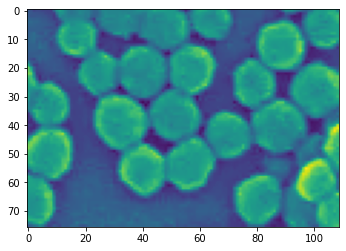

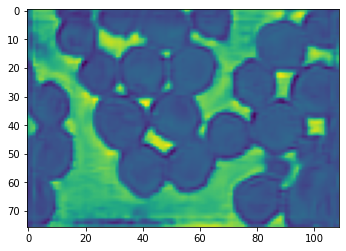

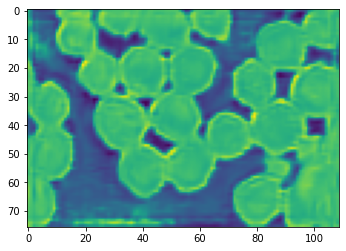

In [76]:
plt.imshow(u1_images[1])
plt.show()
plt.close()
ip = torch.from_numpy(u1_images[1][None,None,:].astype(np.float32))
x1 = model.inc(ip)
x2 = model.down1(x1)
x3 = model.down2(x2)
x4 = model.down3(x3)
x5 = model.down4(x4)
x = model.up1(x5, x4)
x = model.up2(x, x3)
x = model.up3(x, x2)
x = model.up4(x, x1)
x = model.out(x)
pred = x
pred_np=pred.detach().numpy()
for i in pred_np[0]:
    plt.imshow(i)
    plt.show()
    plt.close()
    